# Facies Identification from Well Logs  using Machine Learning


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

import warnings
warnings.filterwarnings("ignore")

## 1. Load, Visualization and Exploration of Data

### 1.1. Data Load

In [2]:
#Load data
data = pd.read_csv('Facies_vectors.csv')
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [3]:
#Label of Facies
labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS'] 
data['Facies_Label']=np.select([data['Facies'] == 1,
                                data['Facies'] == 2,
                                data['Facies'] == 3,
                                data['Facies'] == 4,
                                data['Facies'] == 5,
                                data['Facies'] == 6,
                                data['Facies'] == 7,
                                data['Facies'] == 8,
                                data['Facies'] == 9,]
                                ,labels,default='')

In [4]:
#Unique items in a column that is categorical
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')
data['Facies_Label'] = data['Facies_Label'].astype('category')

In [5]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_Label
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


### 1.2. Visualization

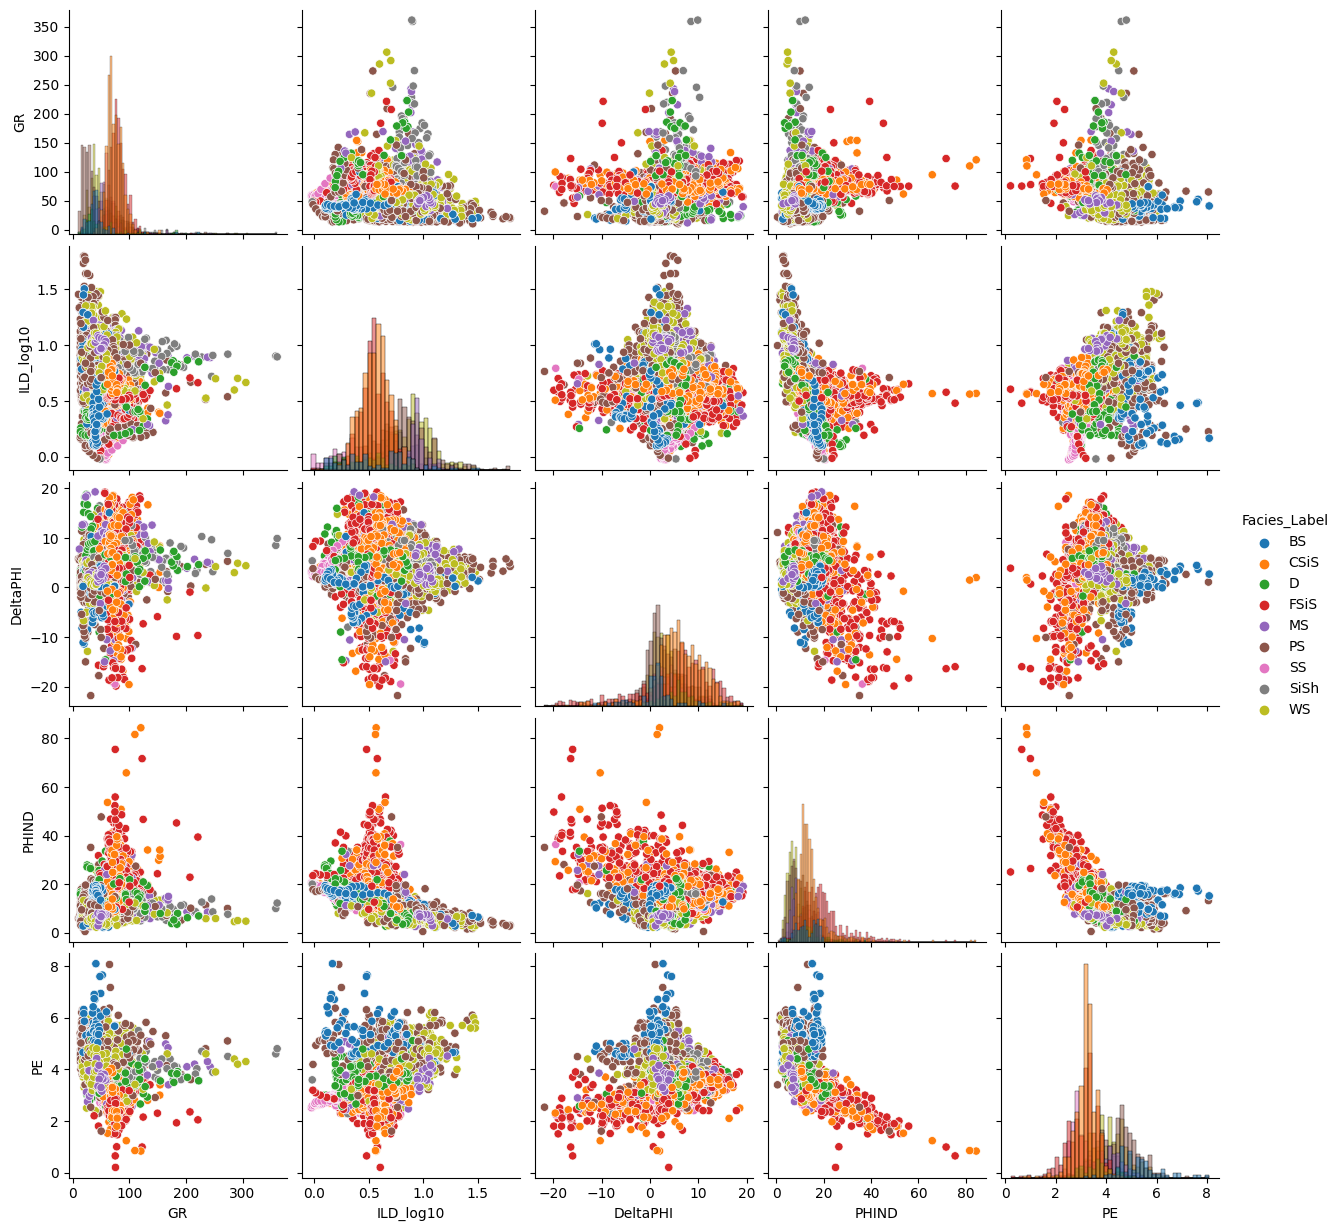

In [6]:
sns.pairplot(data.drop(['Facies','NM_M','RELPOS','Depth'], axis = 1) ,hue='Facies_Label',diag_kind='hist')

#### Well logs plot

In [7]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                   cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

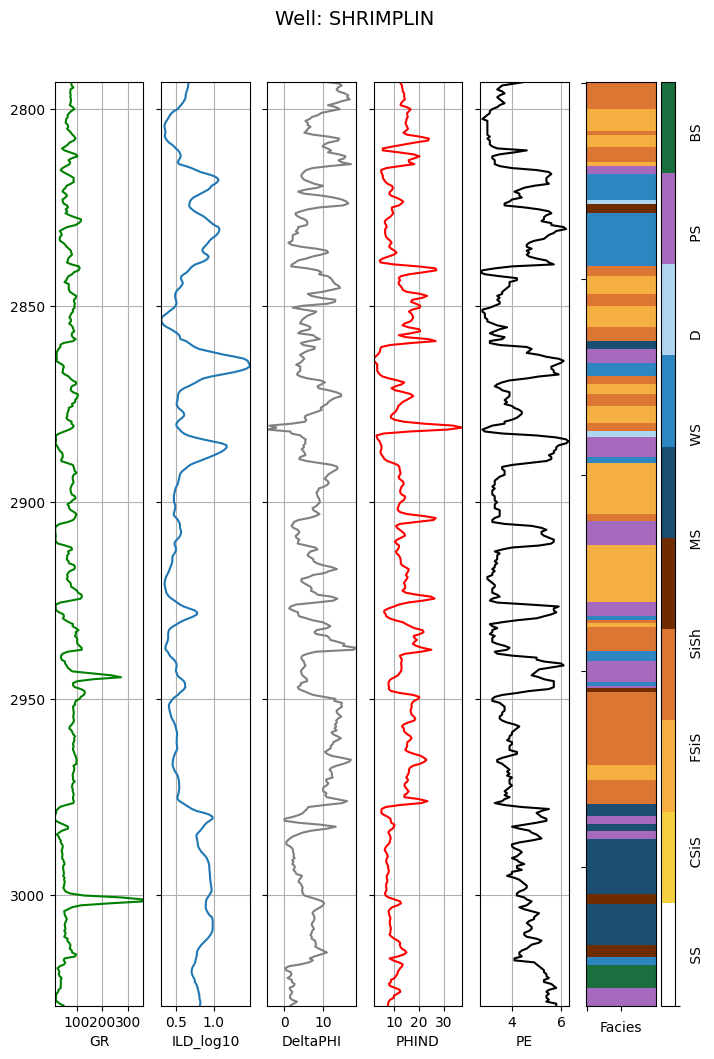

In [8]:
make_facies_log_plot(
    data[data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

<Axes: title={'center': 'Distribution of Facies'}, xlabel='Facies_Label'>

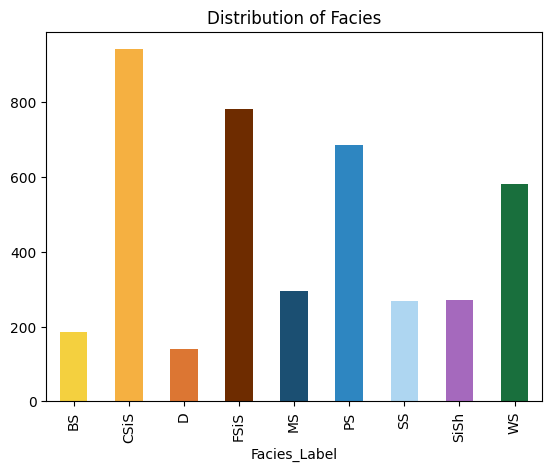

In [9]:
#Bar chart: Distribution of Facies
Facies_dist = data['Facies_Label'].value_counts().sort_index()

Facies_dist.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Facies')

### 1.3. Exploration

In [10]:
#Set Index Depth
data.set_index('Depth',inplace=True)

In [11]:
#Group by Well Name
data.groupby("Well Name").count()

,Facies,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_Label
Well Name,,,,,,,,,,
ALEXANDER D,466,466,466,466,466,466,0,466,466,466
CHURCHMAN BIBLE,404,404,404,404,404,404,404,404,404,404
CROSS H CATTLE,501,501,501,501,501,501,501,501,501,501
KIMZEY A,439,439,439,439,439,439,0,439,439,439
LUKE G U,461,461,461,461,461,461,461,461,461,461
NEWBY,463,463,463,463,463,463,463,463,463,463
NOLAN,415,415,415,415,415,415,415,415,415,415
Recruit F9,80,80,80,80,80,80,68,80,80,80
SHANKLE,449,449,449,449,449,449,449,449,449,449


In [12]:
#Data Info (For dtype and NaN analysis)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4149 entries, 2793.0 to 3122.5
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Facies        4149 non-null   int64   
 1   Formation     4149 non-null   category
 2   Well Name     4149 non-null   category
 3   GR            4149 non-null   float64 
 4   ILD_log10     4149 non-null   float64 
 5   DeltaPHI      4149 non-null   float64 
 6   PHIND         4149 non-null   float64 
 7   PE            3232 non-null   float64 
 8   NM_M          4149 non-null   int64   
 9   RELPOS        4149 non-null   float64 
 10  Facies_Label  4149 non-null   category
dtypes: category(3), float64(6), int64(2)
memory usage: 305.3 KB


#### Remove missing data

Option 1

In [13]:
#Delete Rows with Missing Data
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3232 entries, 2793.0 to 3122.5
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Facies        3232 non-null   int64   
 1   Formation     3232 non-null   category
 2   Well Name     3232 non-null   category
 3   GR            3232 non-null   float64 
 4   ILD_log10     3232 non-null   float64 
 5   DeltaPHI      3232 non-null   float64 
 6   PHIND         3232 non-null   float64 
 7   PE            3232 non-null   float64 
 8   NM_M          3232 non-null   int64   
 9   RELPOS        3232 non-null   float64 
 10  Facies_Label  3232 non-null   category
dtypes: category(3), float64(6), int64(2)
memory usage: 238.1 KB


Option 2

In [14]:
#Fill missing values with median for column 'PE' in well Recruit F9
#data = data[(data['Well Name'] != 'KIMZEY A') & (data['Well Name'] != 'ALEXANDER D')]
#Rec_F9 = data[data['Well Name'] == "Recruit F9"]
#med=Rec_F9['PE'].median()
#data=data.fillna(value={'PE': med})

#### Accuracy Evaluation in well "SHANKLE"

In [15]:
#Using well "SHANKLE" for accuracy evaluation
test_well = data[data['Well Name'] == 'SHANKLE'] #New data to test
data = data[data['Well Name'] != 'SHANKLE'] 

In [16]:
X = data.drop(['Facies','Formation','Well Name','Facies_Label'], axis = 1) #Features: Feature vector
y = data['Facies'] #Target: Facies

In [17]:
X

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669


## 2. Data Split (Test/Train)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (1948, 7)
Dimensions of X_test: (835, 7)


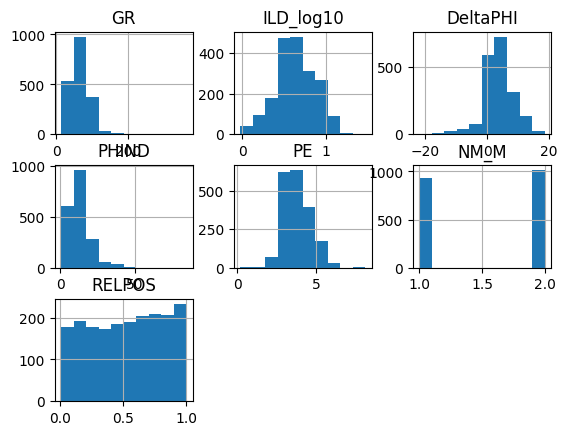

In [19]:
X_train.hist()
plt.show()

In [20]:
X_train

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2931.5,46.813,0.857000,-0.436,4.880,4.273,2,0.902
3004.0,49.860,0.910000,7.600,7.585,4.800,2,0.480
2714.0,15.340,0.792000,0.100,9.750,5.300,2,0.789
3121.5,49.719,0.964000,2.925,8.013,3.190,2,0.669
2857.5,90.313,0.581000,5.634,13.458,3.395,1,0.818
...,...,...,...,...,...,...,...
2809.0,23.688,0.777572,-2.200,9.400,4.449,2,0.971
2927.0,53.125,0.826000,1.122,4.835,4.008,2,1.000
2927.5,73.970,0.498000,5.900,16.850,3.500,1,0.222


#### Dimensionality Reduction (Drop PE)

In [21]:
#Dimensionality Reduction (PE)
#X_train=X_train.drop(['PE'], axis = 1)
#X_test=X_test.drop(['PE'], axis = 1)

## 3. Data Preprocessing

### 3.1. Feature Transform: Robust Scaler

In [22]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler()

In [23]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [65.1225  0.631   3.4995 11.85    3.608   2.      0.5435] 
Original IQR : [35.7625   0.314    5.19425  7.97225  1.2      1.       0.505  ] 
Scaled median : [ 0.00000000e+00  0.00000000e+00 -4.27514469e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.09938100e-16] 
Scaled IQR : [1. 1. 1. 1. 1. 1. 1.] 


In [24]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [ 0.04727019 -0.03327247  0.03860038  0.02333093 -0.00666667  0.
 -0.08613861]
IQR of scaled test data: [0.93463824 1.00955414 1.00110699 1.00034495 1.         1.
 0.93069307] 


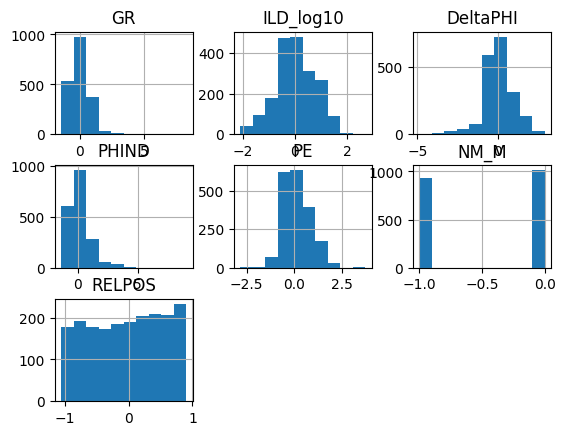

In [25]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist()
plt.show()

In [26]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

In [27]:
X_train

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2931.5,-0.511975,0.719745,-0.757665,-0.874283,0.554167,0.0,0.709901
3004.0,-0.426774,0.888535,0.789431,-0.534981,0.993333,0.0,-0.125743
2714.0,-1.392031,0.512739,-0.654474,-0.263414,1.410000,0.0,0.486139
3121.5,-0.430717,1.060510,-0.110603,-0.481294,-0.348333,0.0,0.248515
2857.5,0.704383,-0.159236,0.410935,0.201700,-0.177500,-1.0,0.543564
...,...,...,...,...,...,...,...
2809.0,-1.158602,0.466789,-1.097271,-0.307316,0.700833,0.0,0.846535
2927.0,-0.335477,0.621019,-0.457718,-0.879927,0.333333,0.0,0.903960
2927.5,0.247396,-0.423567,0.462146,0.627176,-0.090000,-1.0,-0.636634


### 3.2. Outlier Detection: Isolation Forest

In [28]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.08)
iforest = iforest.fit(X_train) #Training the model

In [29]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Predict
Depth,,,,,,,,
2931.5,-0.511975,0.719745,-0.757665,-0.874283,0.554167,0.0,0.709901,1
3004.0,-0.426774,0.888535,0.789431,-0.534981,0.993333,0.0,-0.125743,1
2714.0,-1.392031,0.512739,-0.654474,-0.263414,1.410000,0.0,0.486139,1
3121.5,-0.430717,1.060510,-0.110603,-0.481294,-0.348333,0.0,0.248515,1
2857.5,0.704383,-0.159236,0.410935,0.201700,-0.177500,-1.0,0.543564,1
...,...,...,...,...,...,...,...,...
2809.0,-1.158602,0.466789,-1.097271,-0.307316,0.700833,0.0,0.846535,1
2927.0,-0.335477,0.621019,-0.457718,-0.879927,0.333333,0.0,0.903960,1
2927.5,0.247396,-0.423567,0.462146,0.627176,-0.090000,-1.0,-0.636634,1


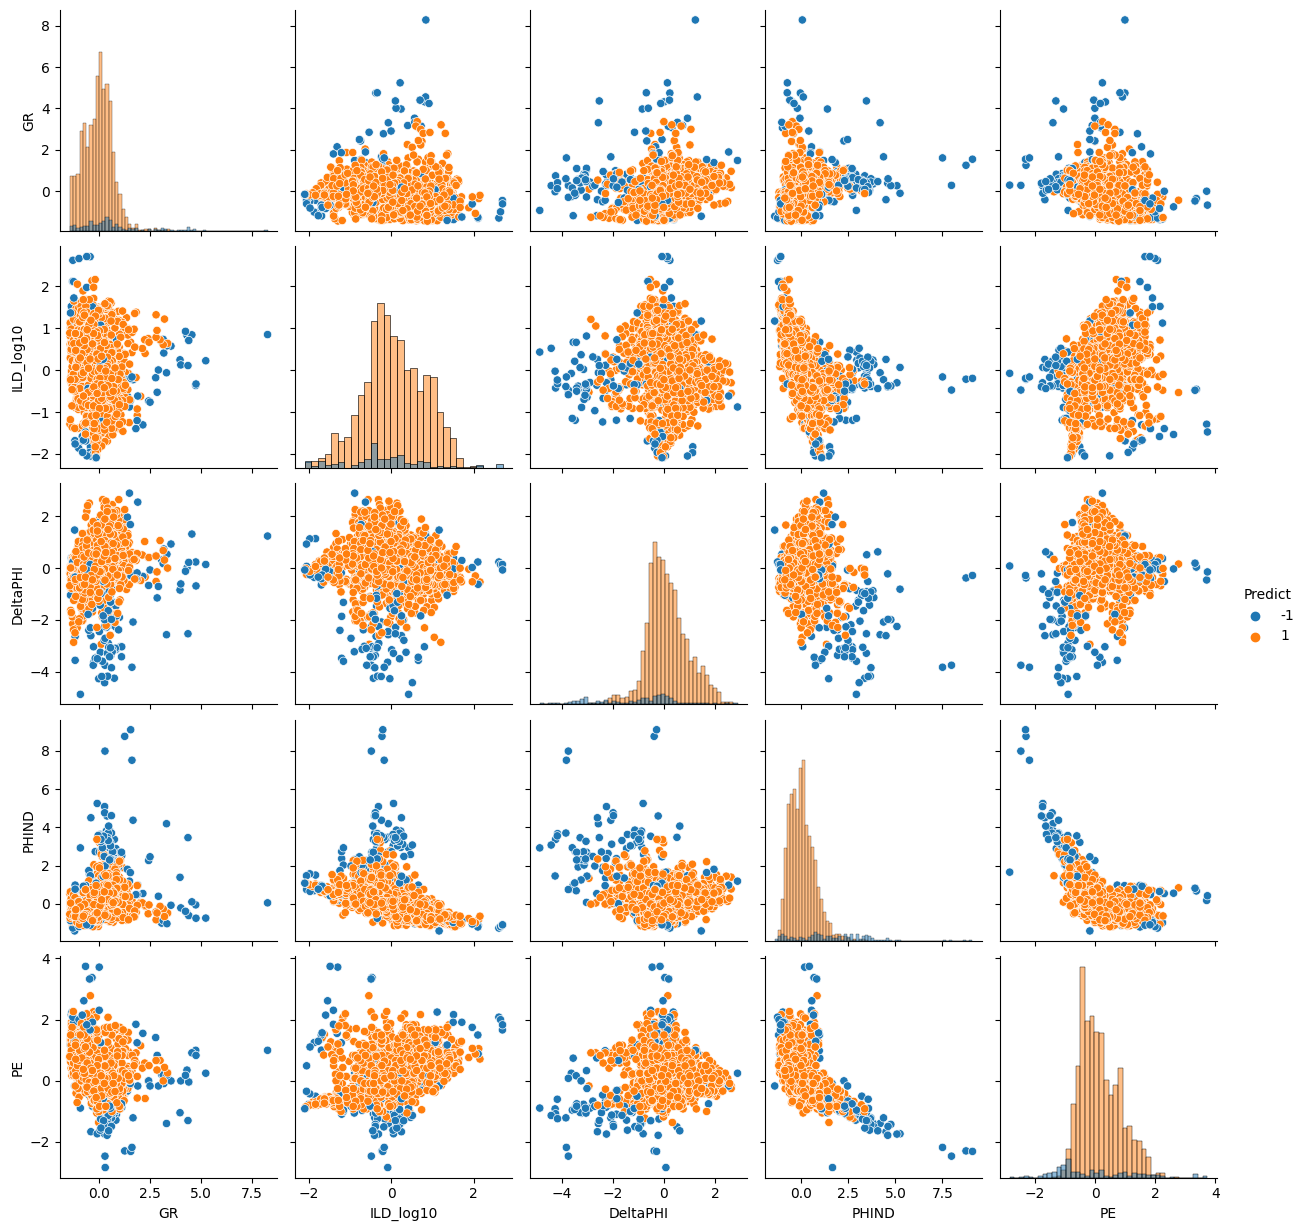

In [30]:
#Visualization
sns.pairplot(X_train.drop(['NM_M','RELPOS'],axis=1),hue='Predict',diag_kind='hist')

In [31]:
#Removing Outliers
X_train['y_train']=y_train
X_train = X_train[X_train['Predict'] == 1]

y_train=X_train['y_train']
X_train = X_train.drop(['Predict','y_train'], axis = 1)

In [32]:
print(len(X_train))
print(len(y_train))

1792
1792


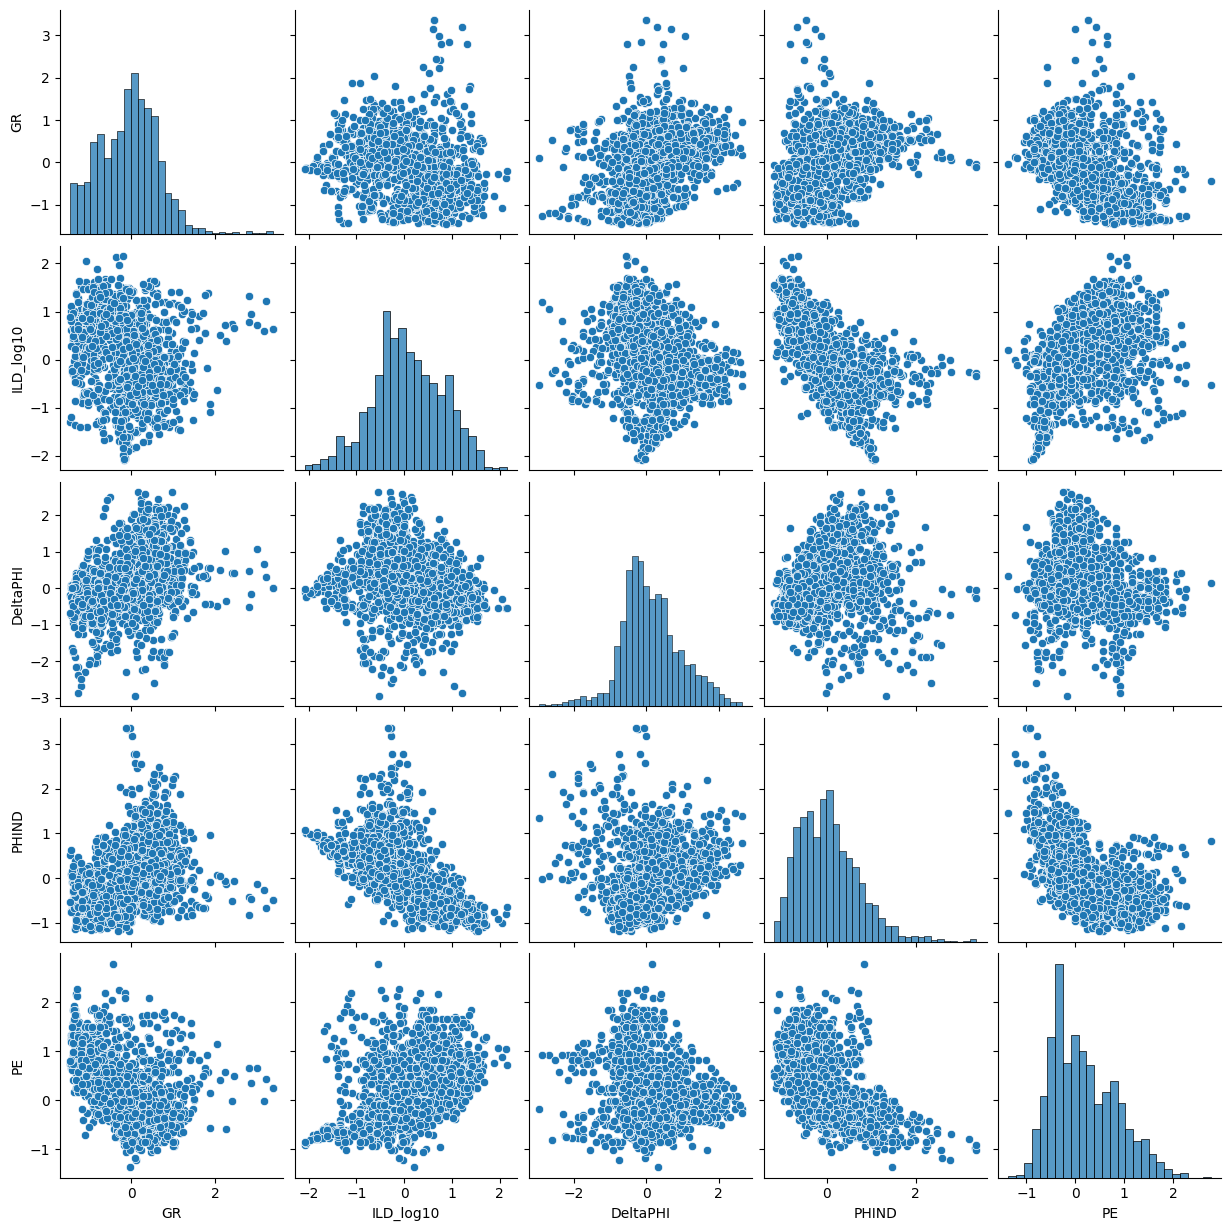

In [33]:
#Visualization Without Outliers
sns.pairplot(X_train.drop(['NM_M','RELPOS'],axis=1),diag_kind='hist')

## 4. Models

### 4.1. Logistic Regression

#### Tuning Hyperparameters

In [34]:
score=[]
score_train=[]
C=[]
for i in range(1,100,1):
    C.append(i/10)
    classifier = LogisticRegression(penalty='l2',C=i/10) 
    classifier.fit(X_train, y_train)
    train_pred = classifier.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = classifier.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

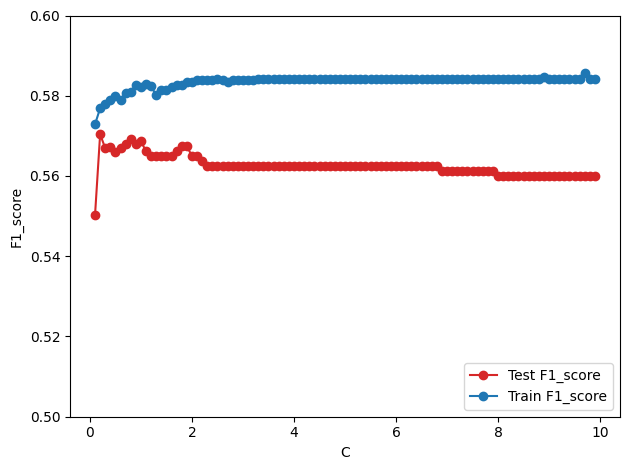

In [35]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('C')
ax1.set_ylabel('F1_score')
ax1.set_ylim([0.5,0.60])
ax1.plot(C, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(C, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Applying Model

In [36]:
classifier = LogisticRegression(C=2) 
classifier.fit(X_train, y_train)

print(classifier.coef_) #a1 and a2
print(classifier.intercept_) # a0

[[-0.58688147 -2.09180967 -0.33154064 -1.82908703 -3.16746753 -3.85166406
   0.10611756]
 [ 0.46626965  0.41259549 -0.01736723 -0.01412552 -1.44647782 -5.13032928
   0.05962694]
 [ 0.98028103  0.31632079  0.19385354  1.5828115   0.18553536 -4.33528724
   0.81464088]
 [ 0.81550277  1.11245917  0.910863    0.26221293 -0.88051767  2.52829018
  -0.69471881]
 [-0.28786032  1.04024384  0.74862016 -0.54495941  0.05839583  1.7603684
   0.46859787]
 [-0.20060893  1.09307836  0.13608746 -0.86074605  0.56760678  2.32077556
  -0.38896532]
 [-0.28208876 -2.13587808  0.7383969  -0.68341307  0.00807793  2.90251307
   0.27265631]
 [-0.50217899 -0.13975079 -0.75252962 -0.10590272  1.42446763  1.50106333
   0.14624439]
 [-0.40243499  0.39274087 -1.62638357  2.19320936  3.2503795   2.30427004
  -0.78419983]]
[-2.31799563 -1.0491447  -1.27153659  1.29598329  1.14284982  1.49195532
  0.42692376  1.79876782 -1.51780308]


In [37]:
prediction = classifier.predict(X_test)

In [38]:
#Compare against true labels (Accuracy)
print('Accuracy (generalization)',classifier.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',classifier.score(X_train,y_train)) #Accuracy (memorization)

Accuracy (generalization) 0.5820359281437125
Accuracy (memorization) 0.5954241071428571


In [39]:
#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,classifier.predict(X_test),average="weighted")) #Accuracy (generalization)  
print('F1_score (memorization)',f1_score(y_train,classifier.predict(X_train),average="weighted")) #Accuracy (memorization)  

F1_score (generalization) 0.5650018846189097
F1_score (memorization) 0.5833609592785349


### 4.3. Support Vector Machine

#### Tuning Hyperparameters

In [40]:
from sklearn.model_selection import GridSearchCV 
  
#Defining parameter range 
Tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svc_mod = GridSearchCV(SVC(), Tuned_parameters, refit = True, verbose = 3) 

In [41]:
svc_mod.fit(X_train, y_train) 
svc_mod.best_estimator_

Fitting 5 folds for each of 41 candidates, totalling 205 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.557 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.570 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.564 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.515 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.499 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.534 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.503 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.528 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.379 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.684 total time=   0.1s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.712 total time=   0.1s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.659 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.680 total time=   0.2s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.674 total time=   0.2s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.673 total time=   0.3s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.679 total time=   0.3s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.645 total time=   0.2s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.596 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.599 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.640 total time=   0.1s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.654 total time=   0.1s
[CV 5/5] END ....C=1000, gam

[CV 5/5] END .....C=1000, degree=4, kernel=poly;, score=0.637 total time=   2.0s


SVC(C=10, gamma=1)

In [42]:
print(svc_mod.best_params_) 

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [43]:
#Performance (Accuracy)
print('Accuracy (generalization)',svc_mod.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',svc_mod.score(X_train,y_train)) #Accuracy (memorization)

#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,svc_mod.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,svc_mod.predict(X_train),average="weighted")) #F1_score (memorization) 

Accuracy (generalization) 0.7077844311377246
Accuracy (memorization) 0.890625
F1_score (generalization) 0.7051411156099527
F1_score (memorization) 0.8902234856791581


#### Applying Model

In [44]:
srbf=SVC(C=10.0,kernel='rbf',gamma=1)
srbf.fit(X_train, y_train)

SVC(C=10.0, gamma=1)

In [45]:
#Performance (Accuracy)
print('Accuracy (generalization)',srbf.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',srbf.score(X_train,y_train)) #Accuracy (memorization)

#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,srbf.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,srbf.predict(X_train),average="weighted")) #F1_score (memorization) 

Accuracy (generalization) 0.7077844311377246
Accuracy (memorization) 0.890625
F1_score (generalization) 0.7051411156099527
F1_score (memorization) 0.8902234856791581


### 4.4. Random Forest

#### Tuning Hyperparameters

In [46]:
#Number of trees
score=[]
t=[]
n_trees=[]
for i in range(10,300,10):
    n_trees.append(i)
    start_time = time.time()
    cforest = RandomForestClassifier(criterion='entropy',n_estimators=i,max_depth=10,random_state=1, n_jobs=2) #Creating Instance
    cforest.fit(X_train, y_train) #Learning the decision boundaries
    y_pred = cforest.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))
    t.append(time.time() - start_time)

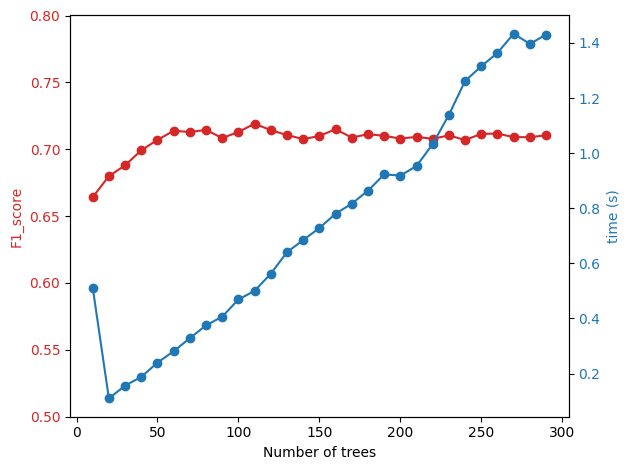

In [47]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of trees')
ax1.set_ylabel('F1_score', color=color)
ax1.set_ylim([0.5,0.8])
ax1.plot(n_trees, score, '-o',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(n_trees, t, '-o',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [48]:
#max_depth
score=[]
max_d=[]
score_train=[]
for i in range(1,30):
    max_d.append(i)
    cforest = RandomForestClassifier(criterion='entropy',n_estimators=200,max_depth=i,random_state=1, n_jobs=2) #Creating Instance
    cforest.fit(X_train, y_train) #Learning the decision boundaries
    train_pred = cforest.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = cforest.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

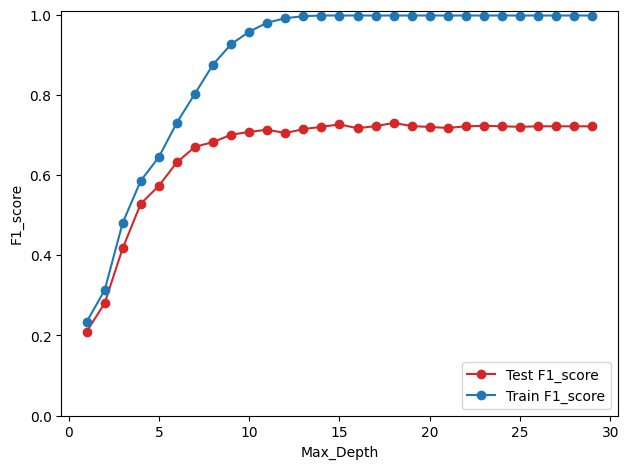

In [49]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Max_Depth')
ax1.set_ylabel('F1_score')
ax1.set_ylim([0,1.01])
ax1.plot(max_d, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(max_d, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [50]:
#min_samples_split
score=[]
score_train=[]
min_samples=[]
for i in range(1,10,2):
    min_samples.append(i/10)
    cforest = RandomForestClassifier(criterion='entropy',n_estimators=200,max_depth=10,min_samples_split=i/10,random_state=1, n_jobs=2) #Creating Instance
    cforest.fit(X_train, y_train) #Learning the decision boundaries
    train_pred = cforest.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = cforest.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

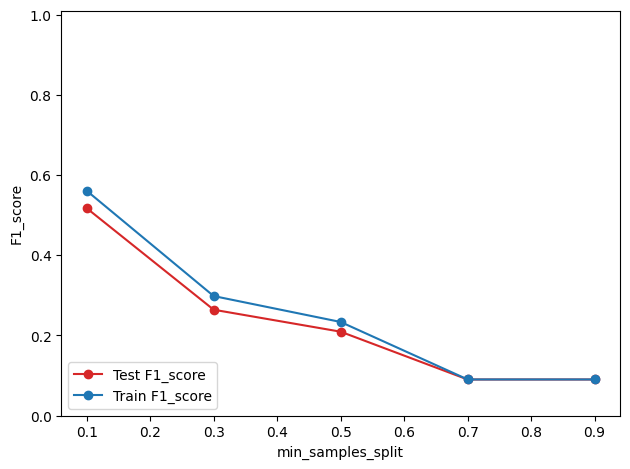

In [51]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('F1_score')
ax1.set_ylim([0,1.01])
ax1.plot(min_samples, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(min_samples, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Applying Model

In [52]:
cforest = RandomForestClassifier(criterion='entropy',n_estimators=200,max_depth=7,random_state=1, n_jobs=2) #Creating Instance
cforest.fit(X_train, y_train) #Learning the decision boundaries
y_pred = cforest.predict(X_test)

In [53]:
#Compare against true labels (Accuracy)
print('Accuracy (generalization)',cforest.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',cforest.score(X_train,y_train)) #Accuracy (memorization)

Accuracy (generalization) 0.6778443113772455
Accuracy (memorization) 0.8069196428571429


In [54]:
#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,cforest.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,cforest.predict(X_train),average="weighted")) #F1_score (memorization)  

F1_score (generalization) 0.67070820862013
F1_score (memorization) 0.8033825171296708


 1) NM_M                           0.277054
 2) PE                             0.163808
 3) GR                             0.155774
 4) ILD_log10                      0.151517
 5) PHIND                          0.108836
 6) DeltaPHI                       0.074863
 7) RELPOS                         0.068147


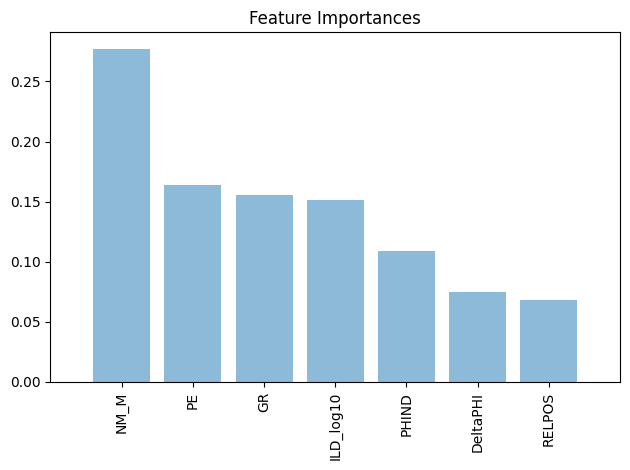

In [55]:
#Feature Importance
importances = cforest.feature_importances_
# get sort indices in descending order

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X.columns.values[indices[f]], importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices],align='center',alpha=0.5)

plt.xticks(range(X_train.shape[1]), X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('fig-forest-feature-importances.png', dpi=300)
plt.show()

## 5. Deployment (Predict targets for new dataset)

In [56]:
test_well

,Facies,Formation,Well Name,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_Label
Depth,,,,,,,,,,,
2774.5,2,A1 SH,SHANKLE,98.36,0.642,-0.1,18.685,2.9,1,1.000,CSiS
2775.0,2,A1 SH,SHANKLE,97.57,0.631,7.9,16.745,3.2,1,0.984,CSiS
2775.5,2,A1 SH,SHANKLE,98.41,0.615,12.8,14.105,3.2,1,0.968,CSiS
2776.0,2,A1 SH,SHANKLE,85.92,0.597,13.0,13.385,3.4,1,0.952,CSiS
2776.5,2,A1 SH,SHANKLE,83.16,0.592,12.3,13.345,3.4,1,0.935,CSiS
...,...,...,...,...,...,...,...,...,...,...,...
3006.0,8,C LM,SHANKLE,32.84,1.120,-2.2,3.455,5.1,2,0.060,PS
3006.5,8,C LM,SHANKLE,25.16,1.112,-1.6,2.890,4.8,2,0.045,PS
3007.0,8,C LM,SHANKLE,25.16,1.112,-1.6,2.890,4.8,2,0.030,PS


In [57]:
X = test_well.drop(['Facies','Formation','Well Name','Facies_Label'], axis = 1) #Features: Feature vector
y_test = test_well['Facies'] #Target: Facies

X

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...
3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030


In [58]:
#If PE is removed
#X = test_well.drop(['Facies','Formation','Well Name','PE','Facies_Label'], axis = 1) #Features: Feature vector
#y_test = test_well['Facies'] #Target: Facies

In [59]:
#Scaling
X_test = rscaler.transform(X)
X_test=pd.DataFrame(X_test,index=X.index, columns=X.columns)
X_test

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2774.5,0.929395,0.035032,-0.692978,0.857349,-0.590000,-1.0,0.903960
2775.0,0.907305,0.000000,0.847187,0.614005,-0.340000,-1.0,0.872277
2775.5,0.930793,-0.050955,1.790538,0.282856,-0.340000,-1.0,0.840594
2776.0,0.581545,-0.108280,1.829042,0.192543,-0.173333,-1.0,0.808911
2776.5,0.504369,-0.124204,1.694277,0.187525,-0.173333,-1.0,0.775248
...,...,...,...,...,...,...,...
3006.0,-0.902691,1.557325,-1.097271,-1.053028,1.243333,0.0,-0.957426
3006.5,-1.117441,1.531847,-0.981759,-1.123899,0.993333,0.0,-0.987129
3007.0,-1.117441,1.531847,-0.981759,-1.123899,0.993333,0.0,-1.016832


In [60]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [61]:
test_well.reset_index(inplace = True)

### 5.1. Logistic Regression

In [62]:
y_pred=classifier.predict(X_test)
test_well['Prediction'] = y_pred

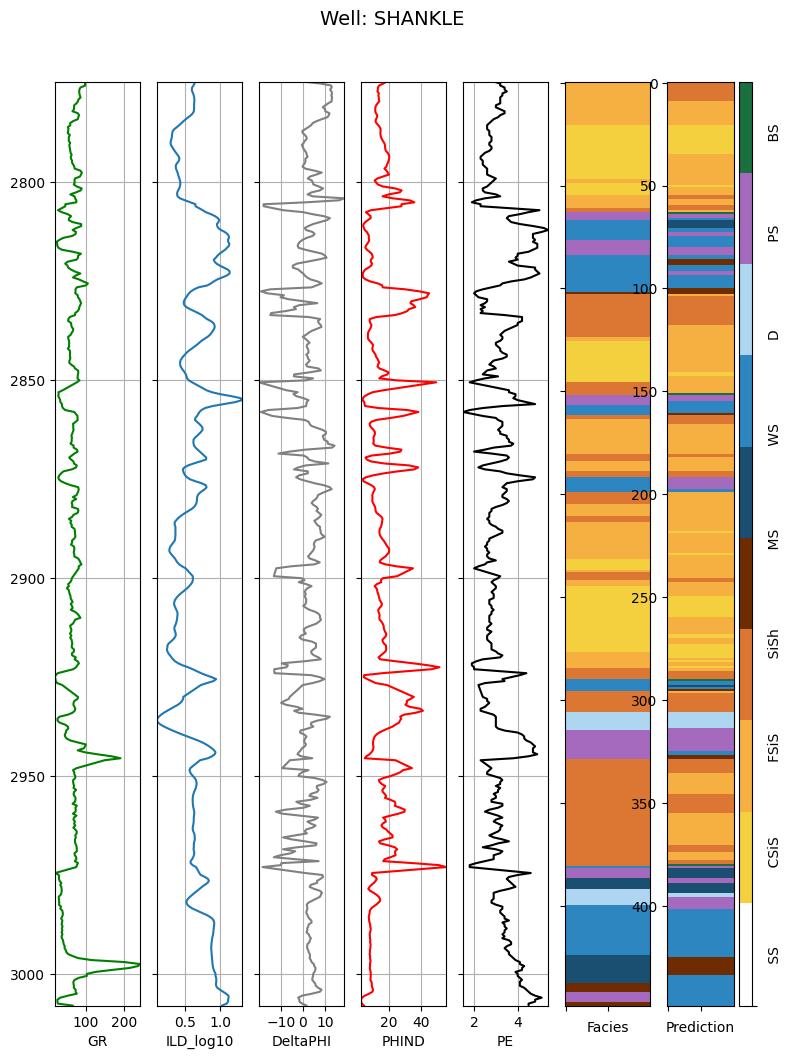

In [63]:
compare_facies_plot(test_well, 'Prediction', facies_colors)

In [64]:
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS','BS']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          SS       0.82      0.37      0.51        89
        CSiS       0.37      0.75      0.49        89
        FSiS       0.79      0.48      0.60       117
        SiSh       0.05      0.14      0.08         7
          MS       0.20      0.16      0.18        19
          WS       0.65      0.63      0.64        71
           D       1.00      0.59      0.74        17
          PS       0.49      0.47      0.48        40
          BS       0.00      0.00      0.00         0

    accuracy                           0.52       449
   macro avg       0.49      0.40      0.41       449
weighted avg       0.64      0.52      0.54       449



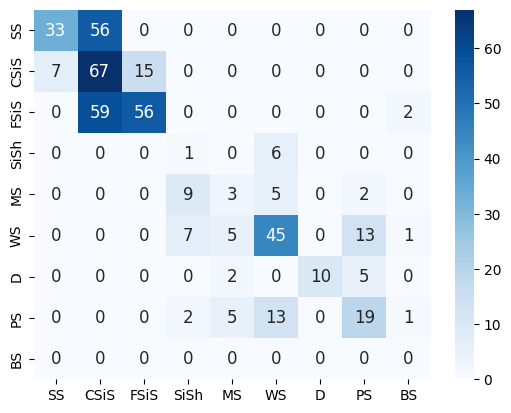

In [65]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=target_names,yticklabels=target_names)

plt.show()

### 5.3. Support Vector Machine

In [66]:
y_pred = srbf.predict(X_test)
test_well['Prediction'] = y_pred

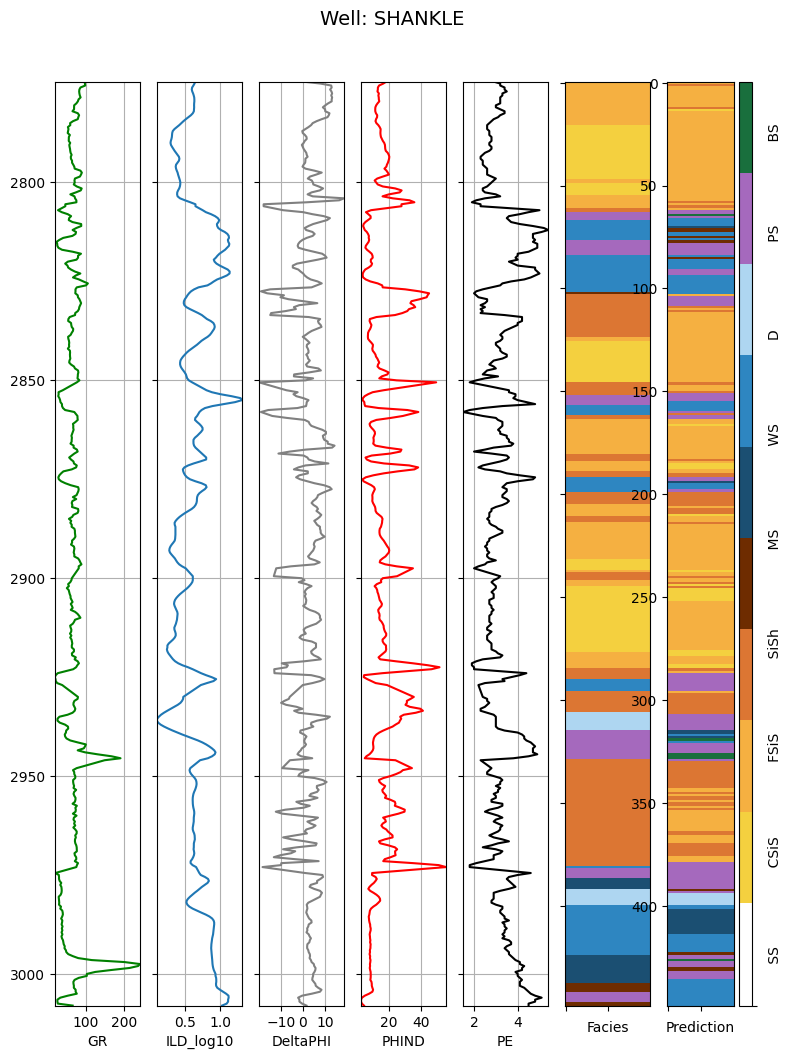

In [67]:
compare_facies_plot(test_well, 'Prediction', facies_colors)

In [68]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          SS       0.37      0.08      0.13        89
        CSiS       0.34      0.75      0.47        89
        FSiS       0.80      0.44      0.56       117
        SiSh       0.00      0.00      0.00         7
          MS       0.00      0.00      0.00        19
          WS       0.66      0.52      0.58        71
           D       1.00      0.35      0.52        17
          PS       0.29      0.53      0.37        40
          BS       0.00      0.00      0.00         0

    accuracy                           0.42       449
   macro avg       0.38      0.30      0.29       449
weighted avg       0.52      0.42      0.41       449



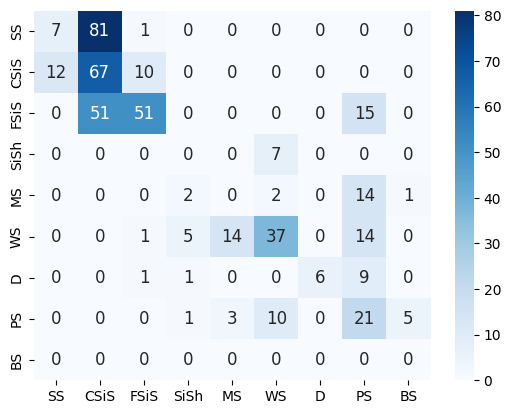

In [69]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=target_names,yticklabels=target_names)

plt.show()

### 5.4. Random Forest

In [70]:
y_pred = cforest.predict(X_test)
test_well['Prediction'] = y_pred

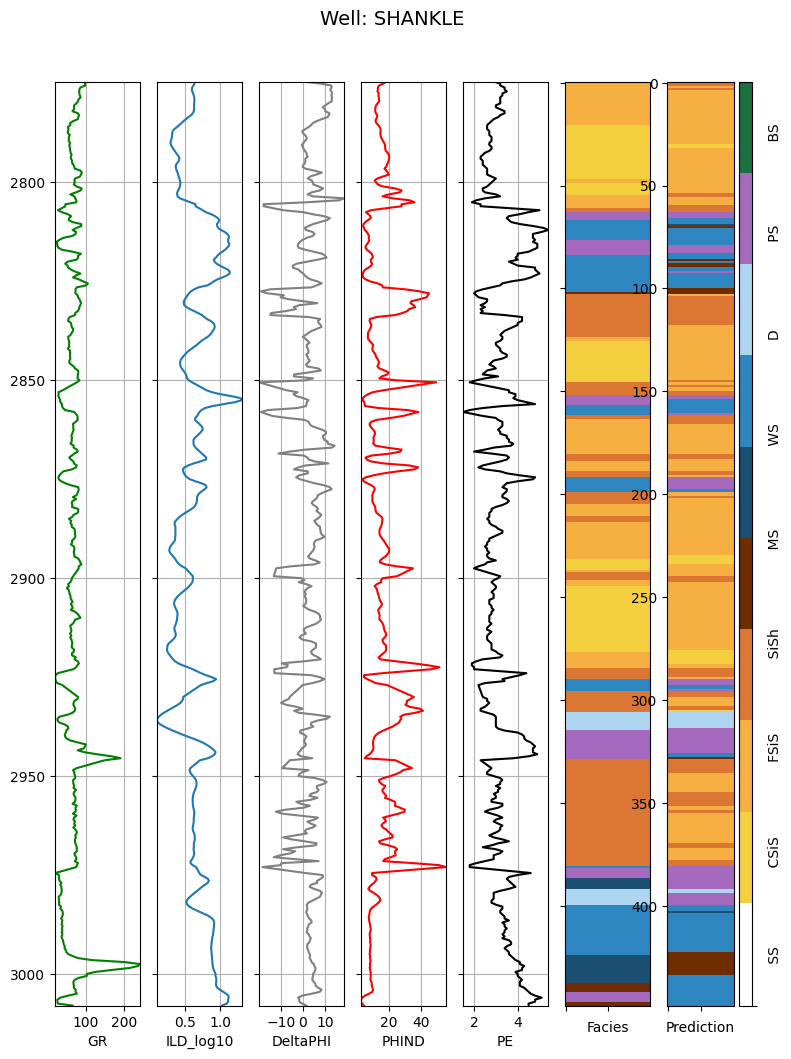

In [71]:
compare_facies_plot(test_well, 'Prediction', facies_colors)

In [72]:
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          SS       0.36      0.06      0.10        89
        CSiS       0.34      0.82      0.48        89
        FSiS       0.85      0.49      0.62       117
        SiSh       0.05      0.14      0.08         7
          MS       0.00      0.00      0.00        19
          WS       0.67      0.69      0.68        71
           D       1.00      0.59      0.74        17
          PS       0.50      0.62      0.56        40

    accuracy                           0.49       449
   macro avg       0.47      0.43      0.41       449
weighted avg       0.55      0.49      0.46       449



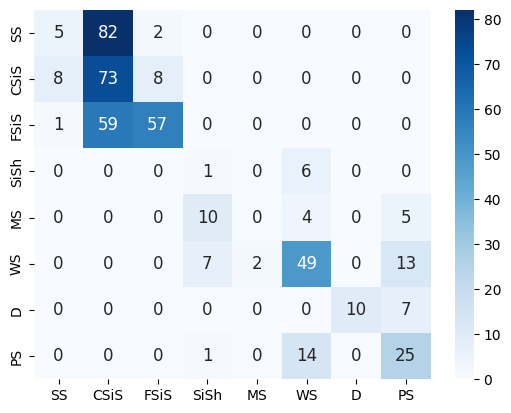

In [73]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=target_names,yticklabels=target_names)

plt.show()

## Does Reducing Dimensions help?

In [74]:
## Resetting the variables X and y to point to original training dataset instead of the test_well

X = data.drop(['Facies','Formation','Well Name','Facies_Label'], axis = 1) #Features: Feature vector
y = data['Facies'] #Target: Facies

In [75]:
## Performing Train Test split exactly as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (1948, 7)
Dimensions of X_test: (835, 7)


In [76]:
#Scaling using the same Robust Scaler as used before

rscaler.fit(X_train)

X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

X_test_scaled  = rscaler.transform(X_test) #Scale the test data using the parameters learnt from the training dataset

X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

#Outlier Removal
iforest.fit(X_train) #Training the model

#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')

#Removing Outliers
X_train['y_train']=y_train
X_train = X_train[X_train['Predict'] == 1]

y_train=X_train['y_train']
X_train = X_train.drop(['Predict','y_train'], axis = 1)

In [77]:
print(len(y_train))
X_train #Data ready to be used with Scaling and Outlier Removal done as before

1792


,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2931.5,-0.511975,0.719745,-0.757665,-0.874283,0.554167,0.0,0.709901
3004.0,-0.426774,0.888535,0.789431,-0.534981,0.993333,0.0,-0.125743
2714.0,-1.392031,0.512739,-0.654474,-0.263414,1.410000,0.0,0.486139
3121.5,-0.430717,1.060510,-0.110603,-0.481294,-0.348333,0.0,0.248515
2857.5,0.704383,-0.159236,0.410935,0.201700,-0.177500,-1.0,0.543564
...,...,...,...,...,...,...,...
2809.0,-1.158602,0.466789,-1.097271,-0.307316,0.700833,0.0,0.846535
2927.0,-0.335477,0.621019,-0.457718,-0.879927,0.333333,0.0,0.903960
2927.5,0.247396,-0.423567,0.462146,0.627176,-0.090000,-1.0,-0.636634


In [78]:
from sklearn.feature_selection import f_classif, chi2

# f_classif is used when one variable (feature) is categorical and the other (target) is continuous
# chi square is used when we have two categorical variables (e.g., gender and alive/dead) 

In [79]:
F, p = f_classif(X_train, y_train)  #learn preprocessing from train

# large p are lower importance feature
# small p are higher importance feature

Text(0.5, 0, 'features')

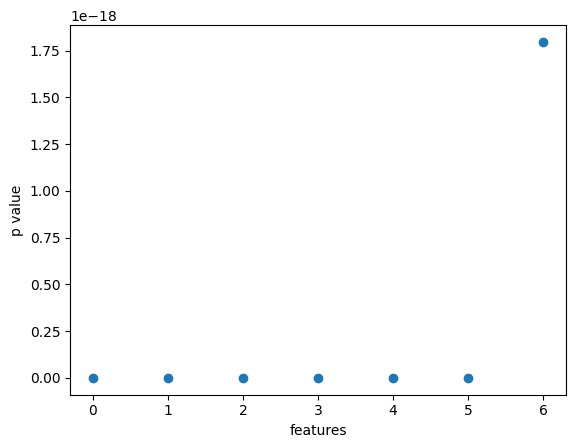

In [80]:
plt.figure()
plt.plot(p, 'o')
plt.ylabel('p value')
plt.xlabel('features')

Text(0.5, 0, 'features')

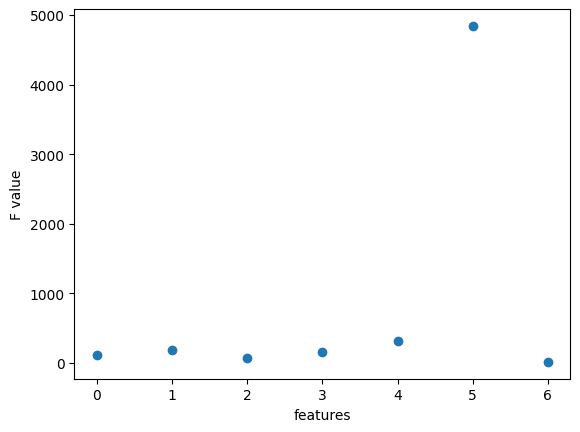

In [81]:
plt.figure()
plt.plot(F, 'o')
plt.ylabel('F value')
plt.xlabel('features')

A large f value and a small p value means the feature is significant

Low p-value indicates informative features

Here, in this case, all features seem to be really important given the very low p values.

In [82]:
print('no. of features with p-value < threshold: {}'.format(len(p[p<0.00001])))

no. of features with p-value < threshold: 7


In [83]:
#### Compute the threshold for feature selection#SelectPercentile, 
### which selects a percentile of the original features (we select 50%)
# We have to define a threshold on the p-value of the statistical test to decide how many features to keep. 

from sklearn.feature_selection import SelectPercentile

# use SelectPercentile to select 30% of features:

select = SelectPercentile(percentile=90)
select.fit(X_train, y_train)

# transform training set by reducing number of features:
X_train_red = select.transform(X_train)

# transform training set by reducing number of features:
X_test_red = select.transform(X_test)

print("before: {}".format(X_train.shape))
print("after: {}".format(X_train_red.shape))

before: (1792, 7)
after: (1792, 6)


[ True  True  True  True  True  True False]


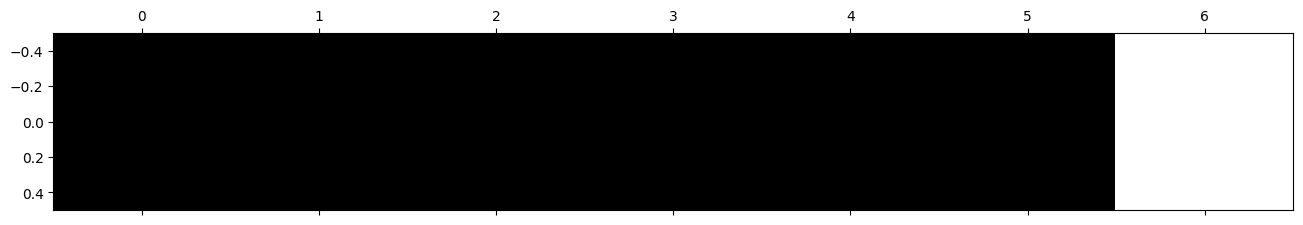

In [84]:
mask = select.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [85]:
print('Column Eliminated = ',X_train.columns[~mask])

Column Eliminated =  Index(['RELPOS'], dtype='object')


In [86]:
X_train[X_train.columns[mask]] # Reduced Dimension Data finally used == X_train_red

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M
Depth,,,,,,
2931.5,-0.511975,0.719745,-0.757665,-0.874283,0.554167,0.0
3004.0,-0.426774,0.888535,0.789431,-0.534981,0.993333,0.0
2714.0,-1.392031,0.512739,-0.654474,-0.263414,1.410000,0.0
3121.5,-0.430717,1.060510,-0.110603,-0.481294,-0.348333,0.0
2857.5,0.704383,-0.159236,0.410935,0.201700,-0.177500,-1.0
...,...,...,...,...,...,...
2809.0,-1.158602,0.466789,-1.097271,-0.307316,0.700833,0.0
2927.0,-0.335477,0.621019,-0.457718,-0.879927,0.333333,0.0
2927.5,0.247396,-0.423567,0.462146,0.627176,-0.090000,-1.0


### Comparing Generalization Accuracy Scores to check if Reduction in Dimensions Improves it
#### Logistic Regression

In [87]:
classifier = LogisticRegression(C=2) 
classifier_red = LogisticRegression(C=2)

classifier.fit(X_train, y_train)
print("Score with all scaled features: %f" % classifier.score(X_test, y_test))

classifier_red.fit(X_train_red, y_train)
print("Score with only selected scaled features: %f" % classifier_red.score(X_test_red, y_test))

Score with all scaled features: 0.582036
Score with only selected scaled features: 0.562874


#### Support Vector Machine Classifier

In [88]:
srbf=SVC(C=10.0,kernel='rbf',gamma=1)
srbf_red = SVC(C=10.0,kernel='rbf',gamma=1)

srbf.fit(X_train, y_train)
print("Score with all scaled features: %f" % srbf.score(X_test, y_test))

srbf_red.fit(X_train_red, y_train)
print("Score with only selected scaled features: %f" % srbf_red.score(X_test_red, y_test))

Score with all scaled features: 0.701796
Score with only selected scaled features: 0.643114


#### Random Forest

In [89]:
cforest = RandomForestClassifier(criterion='entropy',n_estimators=200,max_depth=7,random_state=1, n_jobs=2)
cforest_red = RandomForestClassifier(criterion='entropy',n_estimators=200,max_depth=7,random_state=1, n_jobs=2)

cforest.fit(X_train, y_train)
print("Score with all scaled features: %f" % cforest.score(X_test, y_test))

cforest_red.fit(X_train_red, y_train)
print("Score with only selected scaled features: %f" % cforest_red.score(X_test_red, y_test))

Score with all scaled features: 0.671856
Score with only selected scaled features: 0.632335


### Since we see a reduction in performance in terms of generalization accuracy score for every model built 
### Dimensionality Reduction does not help this case since the number of features is already very low